In [5]:
!pip install lime shap tensorflow

## Introduction

In [6]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from keras.optimizers import Adam, SGD, RMSprop, Adagrad
from keras.losses import MeanSquaredError, MeanAbsoluteError, Huber
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
import numpy as np
import matplotlib.pyplot as plt

import lime
import lime.lime_tabular
import shap

In [7]:
df = pd.read_csv('/content/machine_performance_random_1000_dataset_V2.csv')

In [8]:
df.head()

,Machine,Temps ouverture (heures),Arret planifie (heures),Duree de panne (heures),Ecart de cadence (heures),Nombre de piece bonne,Cadence de production (piees/minute)
0,M1,15,1.156961,1.099763,0.662674,757,60
1,M2,15,1.211035,0.855025,0.317592,695,51
2,M3,15,2.136547,1.071865,0.429608,872,64
3,M4,16,1.359729,1.190878,0.409812,653,53
4,M1,16,1.540807,0.630224,0.180200,648,51


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Machine                               1000 non-null   object 
 1   Temps ouverture (heures)              1000 non-null   int64  
 2   Arret planifie (heures)               1000 non-null   float64
 3   Duree de panne (heures)               1000 non-null   float64
 4   Ecart de cadence (heures)             1000 non-null   float64
 5   Nombre de piece bonne                 1000 non-null   int64  
 6   Cadence de production (piees/minute)  1000 non-null   int64  
dtypes: float64(3), int64(3), object(1)
memory usage: 54.8+ KB


In [10]:
df.describe()

,Temps ouverture (heures),Arret planifie (heures),Duree de panne (heures),Ecart de cadence (heures),Nombre de piece bonne,Cadence de production (piees/minute)
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,16.040000,1.761091,1.004005,0.400539,743.682000,57.298000
std,0.813057,0.441670,0.284758,0.173728,86.111754,4.362824
min,15.000000,1.000078,0.501277,0.100648,600.000000,50.000000
25%,15.000000,1.371877,0.761208,0.251688,665.750000,53.000000
50%,16.000000,1.760350,1.004638,0.397701,739.000000,57.000000
75%,17.000000,2.150677,1.254102,0.547564,818.000000,61.000000
max,17.000000,2.498946,1.498743,0.698356,899.000000,64.000000


# Partie 1 : Analyse industrielle et modélisation

## 1. Calcul du temps de fonctionnement


In [11]:
# Calcul du temps de fonctionnement
df['Temps de fonctionnement'] = df['Temps ouverture (heures)'] - df['Arret planifie (heures)'] - df['Duree de panne (heures)']

## 2. Calcul du temps requis

In [12]:
# Calcul du temps requis
df['Temps requis'] = df['Temps de fonctionnement'] - df['Ecart de cadence (heures)']

## 3. Calcul du temps net

In [13]:
# Calcul du temps net
df['Temps net'] = df['Temps requis']

## 4. Calcul du temps utile

In [14]:
# Calcul du temps utile
df['Temps utile'] = df['Nombre de piece bonne'] / (df['Cadence de production (piees/minute)'] * 60)

## 5. Calcul de l'efficacité globale des équipements (TRS)

In [15]:
# Calcul de l'efficacité globale des équipements (TRS)
df['TRS'] = df['Temps utile'] / df['Temps de fonctionnement'] * 100

In [16]:
df.head()

,Machine,Temps ouverture (heures),Arret planifie (heures),Duree de panne (heures),Ecart de cadence (heures),Nombre de piece bonne,Cadence de production (piees/minute),Temps de fonctionnement,Temps requis,Temps net,Temps utile,TRS
0,M1,15,1.156961,1.099763,0.662674,757,60,12.743276,12.080601,12.080601,0.210278,1.650108
1,M2,15,1.211035,0.855025,0.317592,695,51,12.933940,12.616348,12.616348,0.227124,1.756032
2,M3,15,2.136547,1.071865,0.429608,872,64,11.791588,11.361981,11.361981,0.227083,1.925808
3,M4,16,1.359729,1.190878,0.409812,653,53,13.449393,13.039580,13.039580,0.205346,1.526804
4,M1,16,1.540807,0.630224,0.180200,648,51,13.828969,13.648769,13.648769,0.211765,1.531312


# Partie 2 : Intelligence Artificielle avec application d’un ANN

## Étape 1 : Préparation des données

In [17]:
# setting labels and target
X = df[['Temps de fonctionnement', 'Temps requis', 'Temps net', 'Temps utile']]
y = df['TRS']


In [18]:
X.head()

,Temps de fonctionnement,Temps requis,Temps net,Temps utile
0,12.743276,12.080601,12.080601,0.210278
1,12.933940,12.616348,12.616348,0.227124
2,11.791588,11.361981,11.361981,0.227083
3,13.449393,13.039580,13.039580,0.205346
4,13.828969,13.648769,13.648769,0.211765


In [19]:
y.describe()

,TRS
count,1000.000000
mean,1.647677
std,0.258433
min,1.025038
25%,1.453348
50%,1.636043
75%,1.819287
max,2.445386


In [20]:
# Normalisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [21]:
# Séparation des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


## Étape 2 : Application du modèle ANN

### 1.Regression Model

In [22]:
def create_reg_model(optimizer, activation, loss):
    model = Sequential()
    model.add(Dense(64, activation=activation, input_dim=X_train.shape[1]))
    model.add(Dense(32, activation=activation))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss=loss)
    return model

In [23]:
# Function to train the model
def train_model(model, X_train, y_train, epochs=100, batch_size=32, verbose=0):
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

In [24]:
# Function to evaluate the model
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mse, mae, r2

In [25]:
def compare_regression_models(X_train, y_train, X_test, y_test, combinations):
    results = []
    for i, params in enumerate(combinations):
        model = create_reg_model(params['optimizer'], params['activation'], params['loss'])
        train_model(model, X_train, y_train)
        mse, mae , r2 = evaluate_model(model, X_test, y_test)
        results.append({
            'Model': i+1,
            'Optimizer': params['optimizer'],
            'Activation': params['activation'],
            'Loss': params['loss'],
            'MSE': mse,
            'MAE': mae,
            'R2_Score': r2
        })

    # Convert results to a DataFrame
    df_results = pd.DataFrame(results)

    # Plot the results
    df_results.plot(x='Model', y=['MSE', 'MAE'], kind='bar', figsize=(10, 6))
    plt.title('Regression Model Comparison')
    plt.ylabel('Error')
    plt.xlabel('Model Number')
    plt.xticks(rotation=0)
    plt.show()

    df_results.plot(x='Model', y=[ 'R2_Score'], kind='bar', figsize=(10, 6))
    plt.title('Regression Model Comparison')
    plt.ylabel('Error')
    plt.xlabel('Model Number')
    plt.xticks(rotation=0)
    plt.show()

    return df_results

In [26]:
# List of different parameter combinations
combinations = [
    {'optimizer': 'adam', 'activation': 'relu', 'loss': 'mean_squared_error'},
    {'optimizer': 'sgd', 'activation': 'linear', 'loss': 'mean_absolute_error'},
    {'optimizer': 'rmsprop', 'activation': 'tanh', 'loss': 'mean_squared_error'},
    {'optimizer': 'adam', 'activation': 'sigmoid', 'loss': 'mean_absolute_error'},
    {'optimizer': 'adagrad', 'activation': 'tanh', 'loss': 'mean_absolute_error'},
    {'optimizer': 'sgd', 'activation': 'sigmoid', 'loss': 'mean_squared_error'}
]

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


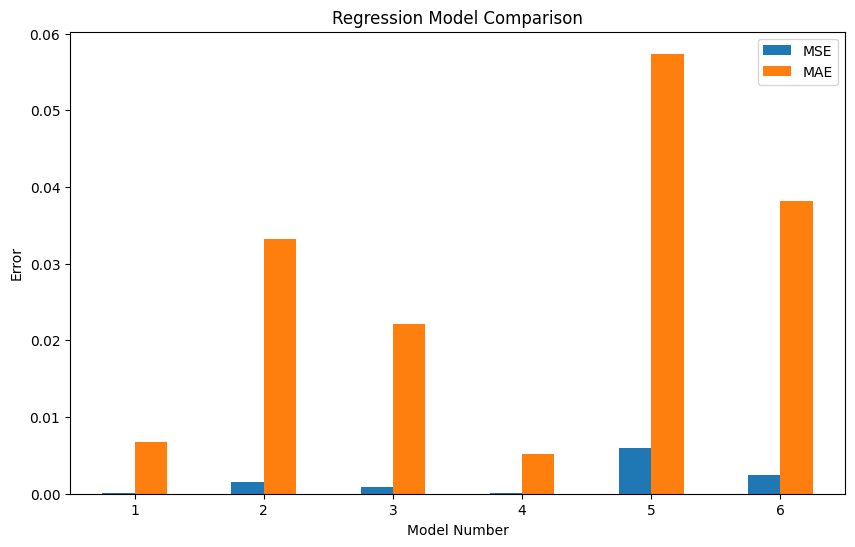

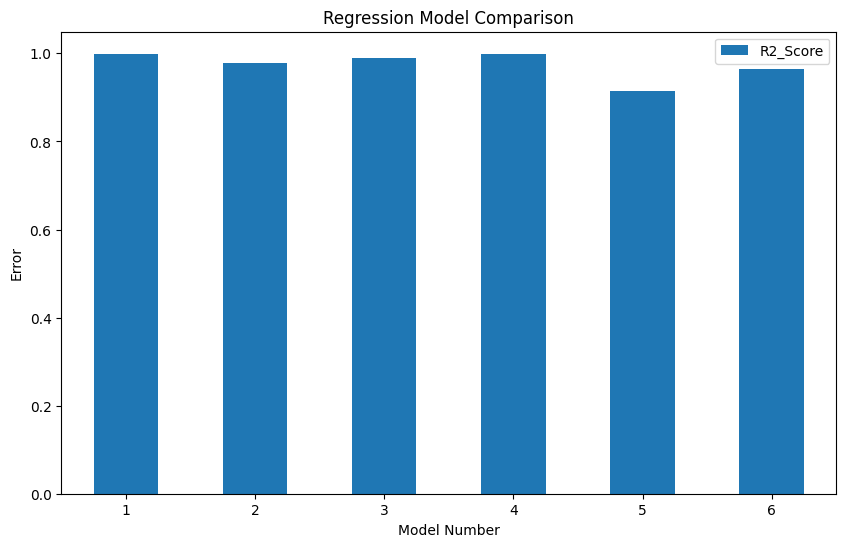

In [27]:
# Compare the models and print the results
results = compare_regression_models(X_train, y_train, X_test, y_test, combinations)

In [40]:
# Identifier le meilleur modèle
best_model_index = results['R2_Score'].idxmax()
best_model_params = results.loc[best_model_index]

print("Meilleur modèle :")
print(best_model_params)

# Recréer et entraîner le meilleur modèle
best_model = create_reg_model(
    best_model_params['Optimizer'],
    best_model_params['Activation'],
    best_model_params['Loss']
)
train_model(best_model, X_train, y_train)

# Faire des prédictions avec le meilleur modèle
y_pred = best_model.predict(X_test)

Meilleur modèle :
Model                           4
Optimizer                    adam
Activation                sigmoid
Loss          mean_absolute_error
MSE                      0.000059
MAE                      0.005126
R2_Score                 0.999172
Name: 3, dtype: object


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [43]:
# Remodeler les données si nécessaire
y_pred = y_pred.reshape(-1)  # ou y_pred.flatten()
y_test_reshaped = y_test.values.reshape(-1) if hasattr(y_test, 'values') else y_test.reshape(-1)


In [44]:
# Calculer les métriques de performance
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("\nMétriques de performance sur l'ensemble de test:")
print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")



Métriques de performance sur l'ensemble de test:
R² Score: 0.7734
RMSE: 0.3332
MAE: 0.2483


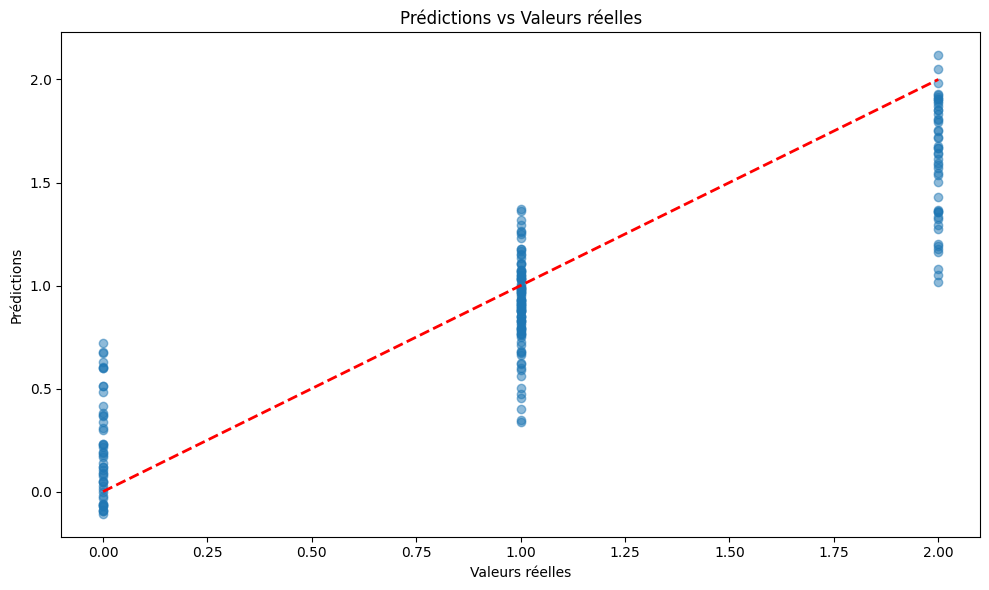

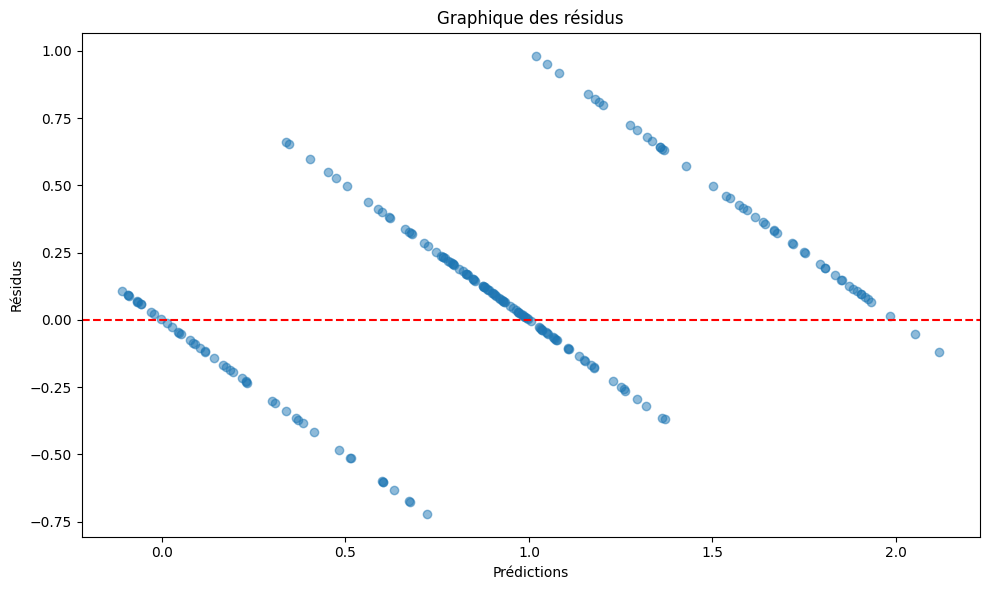

In [45]:
# Visualiser les prédictions vs valeurs réelles
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Valeurs réelles')
plt.ylabel('Prédictions')
plt.title('Prédictions vs Valeurs réelles')
plt.tight_layout()
plt.show()

# Analyse des résidus
residus = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residus, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Prédictions')
plt.ylabel('Résidus')
plt.title('Graphique des résidus')
plt.tight_layout()
plt.show()


In [46]:
# Identifier la machine avec les meilleures prédictions
machine_errors = []
for i in range(len(y_test)):
    error = abs(y_test[i] - y_pred[i])
    machine_errors.append((i, error))

# Trier les machines par erreur (du plus petit au plus grand)
machine_errors.sort(key=lambda x: x[1])

print("\nAnalyse des erreurs par machine:")
for machine_id, error in machine_errors[:5]:  # 5 meilleures machines
    print(f"Machine {machine_id}: Erreur absolue = {error:.4f}")


Analyse des erreurs par machine:
Machine 144: Erreur absolue = 0.0016
Machine 149: Erreur absolue = 0.0026
Machine 42: Erreur absolue = 0.0058
Machine 66: Erreur absolue = 0.0064
Machine 119: Erreur absolue = 0.0099


### 2.Classification Model

In [29]:
# Define bins and labels for TRS categories
bins = [0, 1.453, 1.819, float('inf')]
labels = ['Faible', 'Moyenne', 'Élevée']

# Création de la colonne de catégorie basée sur le TRS
df['trs_category'] = pd.cut(df['TRS'], bins=bins, labels=labels, include_lowest=True)



In [30]:
# Affichage de la distribution des catégories
distribution = df['trs_category'].value_counts().sort_index()
print("Distribution des catégories de TRS :")
print(distribution)

Distribution des catégories de TRS :
trs_category
Faible     250
Moyenne    500
Élevée     250
Name: count, dtype: int64


In [31]:
# Prepare features (X) and target (y)
X = df.drop(['TRS', 'trs_category'], axis=1)
y = df['trs_category']

In [32]:
# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('cat', OneHotEncoder( handle_unknown='ignore'), categorical_features)
    ])

# Preprocess the data
X_preprocessed = preprocessor.fit_transform(X)


In [33]:
# Encode the target variable
le = LabelEncoder()
y = le.fit_transform(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

In [34]:
# Function to create a classification model
def create_classification_model(optimizer, activation, loss):
    model = Sequential()
    model.add(Dense(64, activation=activation, input_dim=X_train.shape[1]))
    model.add(Dense(32, activation=activation))
    model.add(Dense(3, activation='softmax'))  # 3 output neurons for 3 classes
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    return model

In [35]:
# Function to train the classification model
def train_classification_model(model, X_train, y_train, epochs=100, batch_size=32, verbose=0):
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

In [36]:
# Function to evaluate classification model
def evaluate_classification_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    accuracy = accuracy_score(y_test, y_pred_classes)
    precision = precision_score(y_test, y_pred_classes, average='weighted')
    recall = recall_score(y_test, y_pred_classes, average='weighted')
    f1 = f1_score(y_test, y_pred_classes, average='weighted')
    return accuracy, precision, recall, f1


In [37]:
# Function to compare multiple classification models
def compare_classification_models(X_train, y_train, X_test, y_test, combinations):
    results = []
    for i, params in enumerate(combinations):
        model = create_classification_model(params['optimizer'], params['activation'], params['loss'])
        train_classification_model(model, X_train, y_train)
        accuracy, precision, recall, f1 = evaluate_classification_model(model, X_test, y_test)
        results.append({
            'Model': i+1,
            'Optimizer': params['optimizer'],
            'Activation': params['activation'],
            'Loss': params['loss'],
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1
        })

    # Convert results to a DataFrame
    df_results = pd.DataFrame(results)

    # Plot the results
    df_results.plot(x='Model', y=['Accuracy', 'Precision', 'Recall', 'F1-Score'], kind='bar', figsize=(10, 6))
    plt.title('Classification Model Comparison')
    plt.ylabel('Metrics')
    plt.xlabel('Model Number')
    plt.xticks(rotation=0)
    plt.show()

    return df_results

In [38]:
# List of different parameter combinations for classification models
combinations_classification = [
    {'optimizer': 'adam', 'activation': 'relu', 'loss': 'sparse_categorical_crossentropy'},
    {'optimizer': 'sgd', 'activation': 'tanh', 'loss': 'sparse_categorical_crossentropy'},
    {'optimizer': 'rmsprop', 'activation': 'relu', 'loss': 'sparse_categorical_crossentropy'},
    {'optimizer': 'adam', 'activation': 'sigmoid', 'loss': 'sparse_categorical_crossentropy'},
    {'optimizer': 'adamax', 'activation': 'tanh', 'loss': 'sparse_categorical_crossentropy'},
    {'optimizer': 'adagrad', 'activation': 'relu', 'loss': 'sparse_categorical_crossentropy'},
]

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


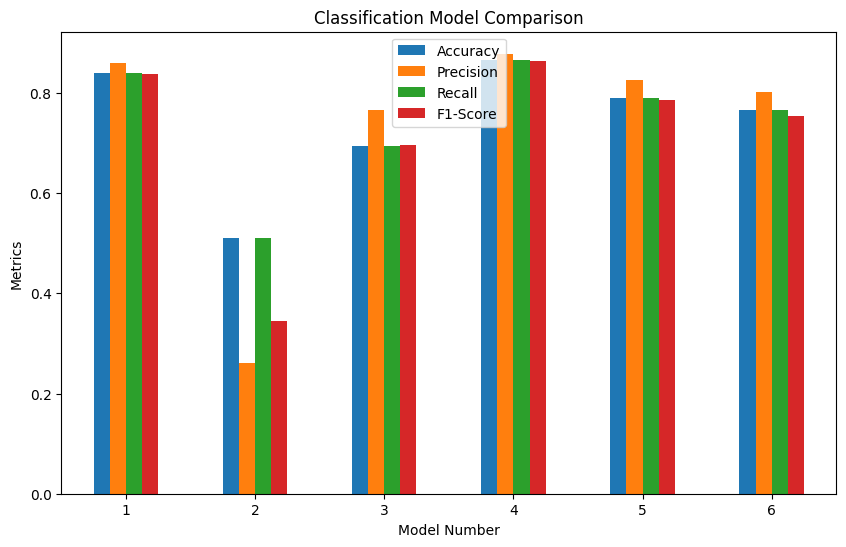

   Model Optimizer Activation                             Loss  Accuracy  \
0      1      adam       relu  sparse_categorical_crossentropy     0.840   
1      2       sgd       tanh  sparse_categorical_crossentropy     0.510   
2      3   rmsprop       relu  sparse_categorical_crossentropy     0.695   
3      4      adam    sigmoid  sparse_categorical_crossentropy     0.865   
4      5    adamax       tanh  sparse_categorical_crossentropy     0.790   
5      6   adagrad       relu  sparse_categorical_crossentropy     0.765   

   Precision  Recall  F1-Score  
0   0.860180   0.840  0.837258  
1   0.260100   0.510  0.344503  
2   0.765991   0.695  0.695391  
3   0.878244   0.865  0.863487  
4   0.825905   0.790  0.785784  
5   0.802590   0.765  0.753158  


In [39]:
# Run the comparison
results_classification = compare_classification_models(X_train, y_train, X_test, y_test, combinations_classification)
print(results_classification)

## Étape 3 : Analyse de la meilleure machine